<a href="https://colab.research.google.com/github/tmpereira/RGB_spectroscopy/blob/main/29-03-21_calibra%C3%A7ao_PLS_R%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# referencias 

https://blog.francium.tech/using-machine-learning-for-color-calibration-with-a-color-checker-d9f0895eafdb

literatura

https://www.sciencedirect.com/science/article/abs/pii/S2352648317300302



# Importando as bibliotecas e github 


In [74]:
import skimage.io as si
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.transform import rescale, resize, downscale_local_mean
import cv2
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression


!git clone https://github.com/tmpereira/RGB_spectroscopy.git

fatal: destination path 'RGB_spectroscopy' already exists and is not an empty directory.


importando o jpg contendo o color target


[255 255 255]


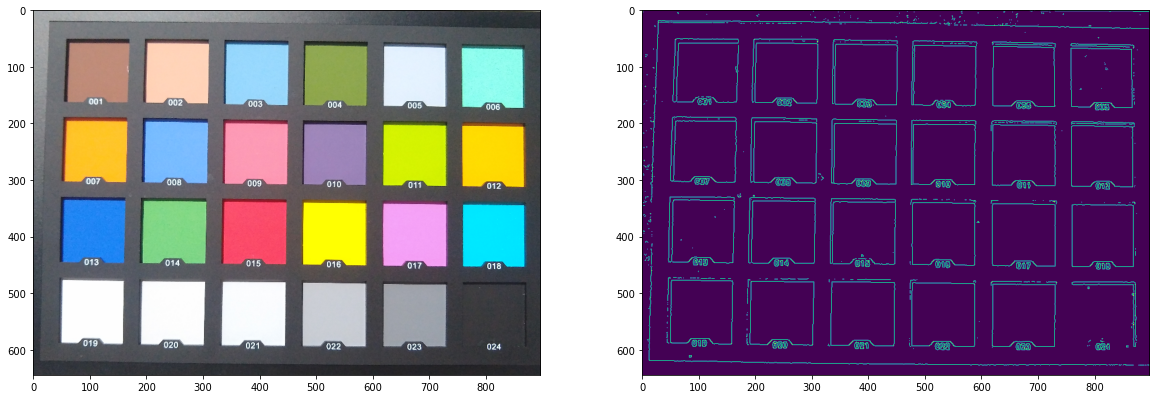

In [75]:
arq = '/content/RGB_spectroscopy/sol.jpg'
img = si.imread(arq)
img = img[450:2600:,610:3600:,::]
imgf = img

# pegando os valores maximos de RGB para normalização depois
maxx = img.reshape(-1,3).max(0)
print(maxx)
# reduzindo a imagem para facilitar o recorte dos quadrinhos
f = 0.3
dim = (int(f*img.shape[1]),int(f*img.shape[0]))
img=cv2.resize(img,dim)

# pré processamento para encontrar a borda dos quadrados 
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
Blur=cv2.GaussianBlur(gray,(5,5),1) #apply blur to roi
Canny=cv2.Canny(Blur,32,32) #apply canny to roi

# vizualizaçao da imagem  inicial e após pré processamento
plt.figure(figsize=(20,15))
plt.subplot(121)
plt.imshow(img)

plt.subplot(122)
plt.imshow(Canny)

#encontrando os quadrados usando cv2


[12165.  12026.  12018.5 11799.5 11796.  11718.  11711.5 11701.  11472.5
 11445.  11367.  11285.  11220.  11200.  11184.  11019.5 10785.5  1426.
  1053.    162.    157.5]


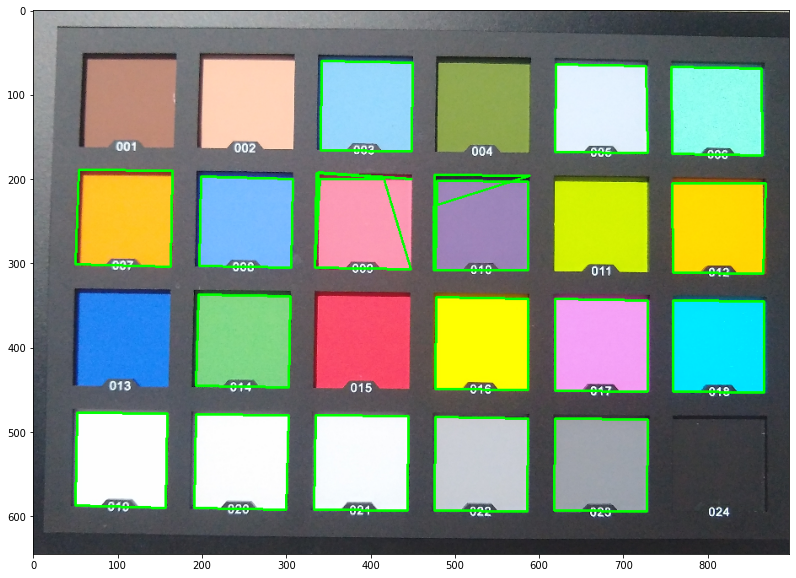

In [76]:
contours =cv2.findContours(Canny,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)[0]
img2 = img.copy()
cntrRect = []
area = []
for i in contours:
        area.append(cv2.contourArea(i))
        epsilon = 0.05*cv2.arcLength(i,True)
        approx = cv2.approxPolyDP(i,epsilon,True)
        if  cv2.contourArea(i) > 8000:
               cv2.drawContours(img2,cntrRect,-1,(0,255,0),2)
               cntrRect.append(approx)
plt.figure(figsize=(15,10))
plt.imshow(img2)
area = np.sort(area)[::-1]
print(area[1:22])

## recortando os quadrados e plotando separadamente

[23 22 21 20 19 18 17 16 14 12  8 10  9  7  6  5  3  2]


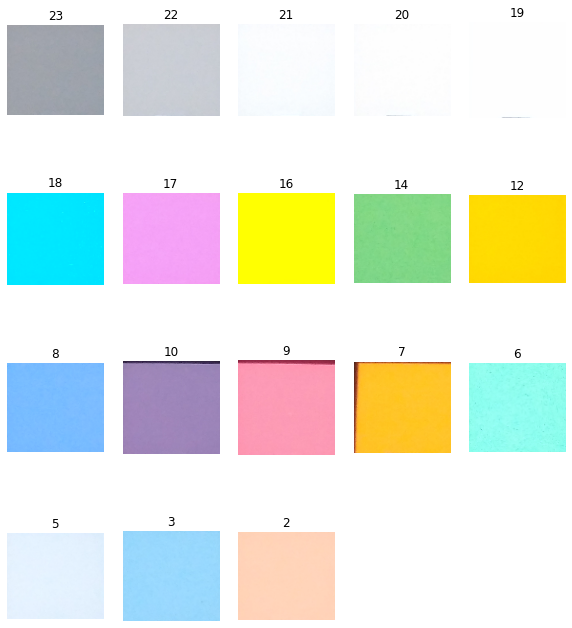

In [77]:

recortes =[] 
labels =np.array([23,22,21,20,19,18,17,16,14,12,8,10,9,7,6,5,3,2])

print(labels)
ii = 0
for i in range(len(cntrRect)):     
    rect = cntrRect[i].reshape(4,-1)
    a = rect[:,1].min()+5
    b = rect[:,1].max()-10
    c = rect[:,0].min()+5
    d = rect[:,0].max()-5
    imgsel = img[a:b,c:d]
    recortes.append(imgsel)

# plotando as imagens recortados com seus respectivos numeros
plt.figure(figsize = (10,15))

for i,imgg in enumerate(recortes):
  plt.subplot(5,5,i+1)
  plt.imshow(imgg)
  plt.axis('off')
  plt.title(labels[i])

# Extraindo os RGBs de cada recorte

In [79]:
RGBmean = [] #np.zeros((labels.shape[0]+1,4))
print(labels)

for i,j in enumerate(recortes):
  RGBmean.append(np.hstack((labels[i],j.reshape(-1,3).mean(0))))
RGBmean = np.array(RGBmean)
RGBmean[:,1:] = RGBmean[:,1:]/RGBmean[4,1:]
Y = 0.2126*RGBmean[:,1] + 0.7152*RGBmean[:,2] + 0.0722*RGBmean[:,3]

#print(np.column_stack((RGBmean,Y)))
RGBmean[:,1:] = RGBmean[:,1:] # / Y.reshape(-1,1)
print(RGBmean)



[23 22 21 20 19 18 17 16 14 12  8 10  9  7  6  5  3  2]
[[2.30000000e+01 6.24798293e-01 6.42840817e-01 6.75907836e-01]
 [2.20000000e+01 7.94346225e-01 8.07759674e-01 8.34969411e-01]
 [2.10000000e+01 9.82270131e-01 9.92383124e-01 1.00180535e+00]
 [2.00000000e+01 9.97345961e-01 9.98164283e-01 9.99374122e-01]
 [1.90000000e+01 1.00000000e+00 1.00000000e+00 1.00000000e+00]
 [1.80000000e+01 4.61897767e-05 9.09033349e-01 1.00407181e+00]
 [1.70000000e+01 9.67129659e-01 6.35370325e-01 9.70551768e-01]
 [1.60000000e+01 1.00463796e+00 1.00398509e+00 4.07473379e-03]
 [1.40000000e+01 5.08085128e-01 8.48508894e-01 5.28761849e-01]
 [1.20000000e+01 1.00442222e+00 8.59820481e-01 6.28599778e-03]
 [8.00000000e+00 4.77389369e-01 7.40724858e-01 1.00407100e+00]
 [1.00000000e+01 6.11146949e-01 5.17045973e-01 7.18410679e-01]
 [9.00000000e+00 9.83311857e-01 5.89318866e-01 6.95711091e-01]
 [7.00000000e+00 9.83655206e-01 7.45224511e-01 1.53326743e-01]
 [6.00000000e+00 5.59328030e-01 9.96889694e-01 9.39673755e-01]

## importando os espectros de absorbancia de HB e HBO2

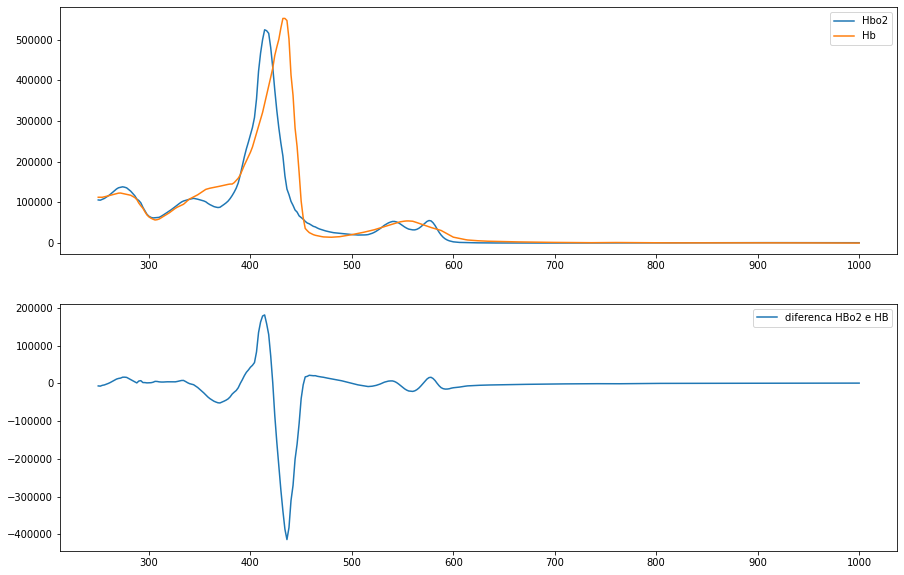

In [ ]:
hb = np.loadtxt('/content/RGB_spectroscopy/prop_Hb.txt',delimiter=';',skiprows=1)
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot(hb[:,0],hb[:,1],hb[:,0],hb[:,2])
plt.legend(['Hbo2','Hb'])
plt.subplot(212)
plt.plot(hb[:,0],hb[:,1]-hb[:,2])
plt.legend(['diferenca HBo2 e HB'])

# importando os espectros de referencia do colortarget e plotando eles


[540. 570. 580.]


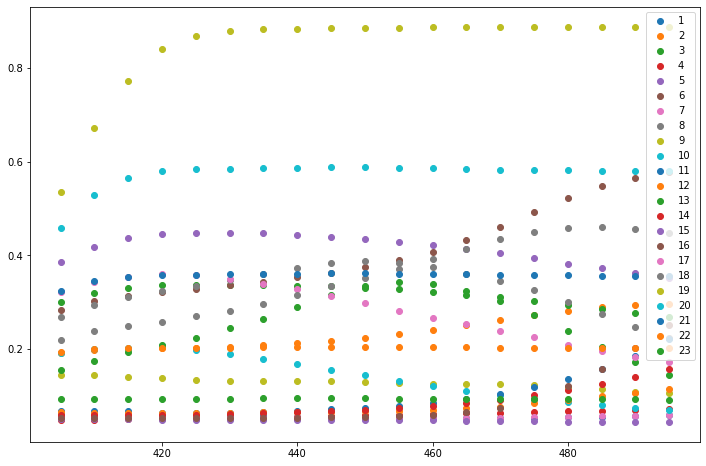

In [82]:
#importando os dados 
mac_data = np.loadtxt('/content/RGB_spectroscopy/MacbethColorChecker_data.csv',delimiter=';')
mac_data = mac_data [::1,:]
#separando a planilha em lambda(wn) e reflectancia (abss)
wn = mac_data[:,0]
indexlamb = [32,38,40]
print(wn[indexlamb])
abss =mac_data[:,1:]


# restriçao de região espectral
sel = (wn > 400) & (wn < 500)
wn = wn[sel]
abss = abss[sel,:]

# inicializando plotando os resultados 
legenda = []
plt.figure(figsize=(12,8))
for i in range(23):
    plt.scatter(wn,abss[:,i])
    legenda.append(str(i+1))
plt.legend(legenda)

## fazendo o PCA dos espectros 

[[-0.59554441 -0.02102373  0.00803517]
 [-0.12306934 -0.03032011 -0.01474614]
 [ 0.54574397 -0.04372206 -0.04315521]
 [ 1.49762714 -0.04087728 -0.05645799]
 [ 2.7081002   0.0570482   0.01489451]
 [ 0.54554059  0.28165939  0.07977609]
 [ 0.22032476 -0.30852027 -0.07993571]
 [-0.63332049  0.20470675 -0.07992023]
 [-0.63811433  0.10872534 -0.0082183 ]
 [-0.67459732  0.05047935 -0.00484514]
 [ 0.42713927 -0.16103694  0.10940182]
 [-0.39420576 -0.22239768 -0.06898482]
 [-0.4495383  -0.06589957 -0.00780766]
 [-0.77145317 -0.0064266   0.01282824]
 [ 0.7759727   0.34220412 -0.04423493]
 [ 0.79855199 -0.1733867  -0.04291583]
 [ 0.36823365 -0.12921164 -0.02371983]
 [ 0.02515433  0.11766019 -0.01098568]]


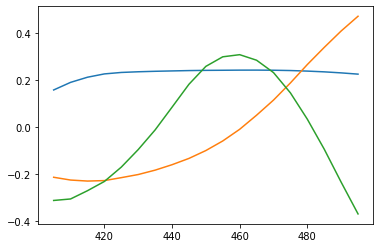

In [83]:
npca = 3
pca = PCA(n_components=npca)
pca.fit(abss.T)

components = pca.components_

for i in range(components.shape[0]):
  plt.plot(wn,components[i,:])

# calculando os scores 
scores = pca.transform(abss.T)

# reorganizando os scores com RGBmean
scores_sel =scores[labels-1,:]
print(scores_sel)
print('========================')



## recuperando o espectro de reflectancia usando PLS-R

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.7394815245515473

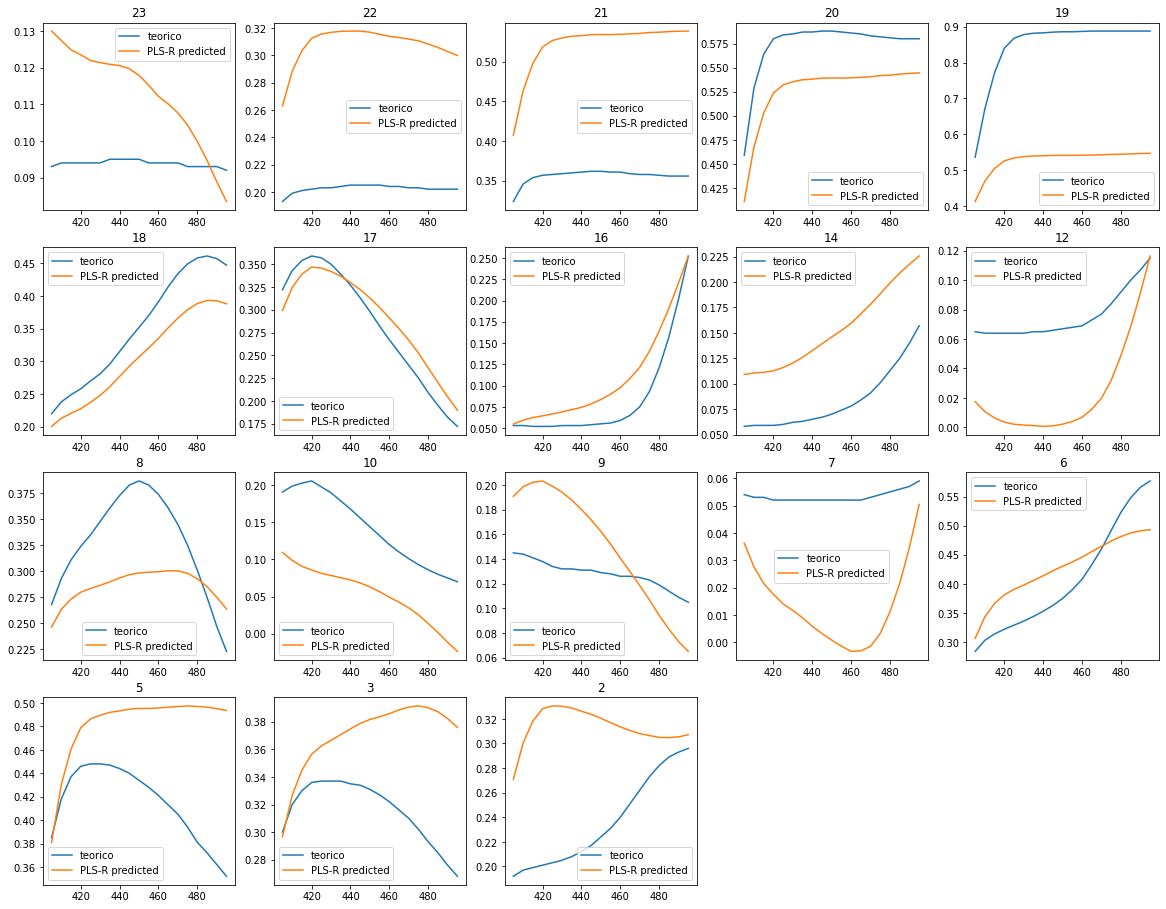

In [84]:
labels =np.array([23,22,21,20,19,18,17,16,14,12,8,10,9,7,6,5,3,2])
Y = abss[:,labels-1].T
X = RGBmean[:,1::]
# calculando PLSR
pls2 = PLSRegression(n_components=3)
pls2.fit(X, Y)
Y_pred = pls2.predict(X)
plt.figure(figsize=(20,20))
for k in range(18):
  plt.subplot(5,5,k+1)
  plt.plot(wn,Y[k,:],wn,Y_pred[k,:])
  plt.title(labels[k])
  plt.legend(['teorico', 'PLS-R predicted'])
pls2.score(X,Y)



## convertendo RGB para XYZ usando regressão multipla

[referencia xyY -> XYZ](http://www.brucelindbloom.com/index.html?Eqn_xyY_to_XYZ.html)

soma dos residuos é [3986.83503113 4246.39602319 5589.49727213]


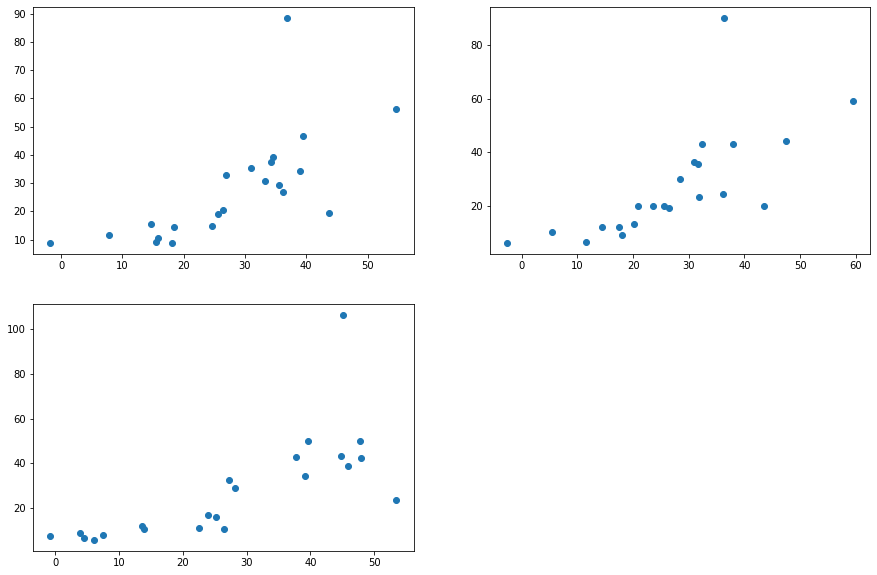

In [ ]:
xyY = np.loadtxt('/content/RGB_spectroscopy/xyY_macbeth.txt',delimiter=';',skiprows=1)
xyY = xyY[:,1::]
x = xyY[:,0]
y = xyY[:,1]
Y = xyY[:,2]
# criando a matriz XYZ
XYZ = np.zeros_like(xyY)
XYZ[:,0] = x*Y/y
XYZ[:,1] = Y
XYZ[:,2] =  ((1-x-y)*Y)/y

# fazendo o PLS-R

Y = XYZ[labels-1,:]
X = RGBmean
X[:,0] = 1

# calculando regressão multipla
XX = np.linalg.lstsq(X, Y, rcond=-1)
print('soma dos residuos é ' + str(XX[1]))
XX = XX[0]
res = X@XX

plt.figure(figsize=(15,10))
plt.subplot(221)
plt.scatter(res[:,0],Y[:,0])


plt.subplot(222)
plt.scatter(res[:,1],Y[:,1])


plt.subplot(223)
plt.scatter(res[:,2],Y[:,2])